In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'********************',
                      'user':'********', 
                      'password':'**********'
                     }

Эксперимент проходил с 2023-01-31 по 2023-02-06 включительно. Для эксперимента были задействованы 2 и 1 группы. 
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

<b>Задача — проанализировать данные АB-теста</b> 

In [3]:
# Выбираем пользователей из групп 1 (контрольная) и 2 (экспериментальная) с учетом периода времени AB тестирования нового алгоритма
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2023-01-31' and toDate(time) <= '2023-02-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

In [4]:
df = ph.read_clickhouse(q, connection=connection)

In [5]:
#Settings for graphs
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [6]:
# significance level
alpha = 0.05

Распределение индивидуальных CTR по пользователям в группах 1 (red) и 2 (blue): 

<AxesSubplot:xlabel='ctr', ylabel='Count'>

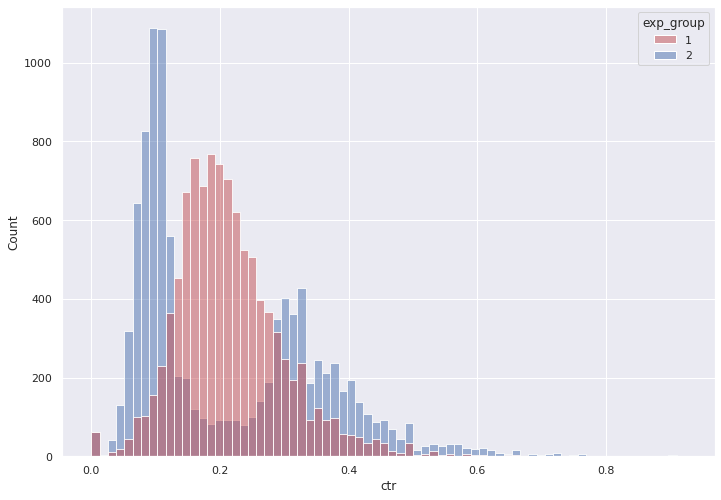

In [7]:
sns.histplot(data = df,
x='ctr',
hue='exp_group',
palette = ['r', 'b'],
alpha=0.5,
kde=False)

<AxesSubplot:xlabel='exp_group', ylabel='ctr'>

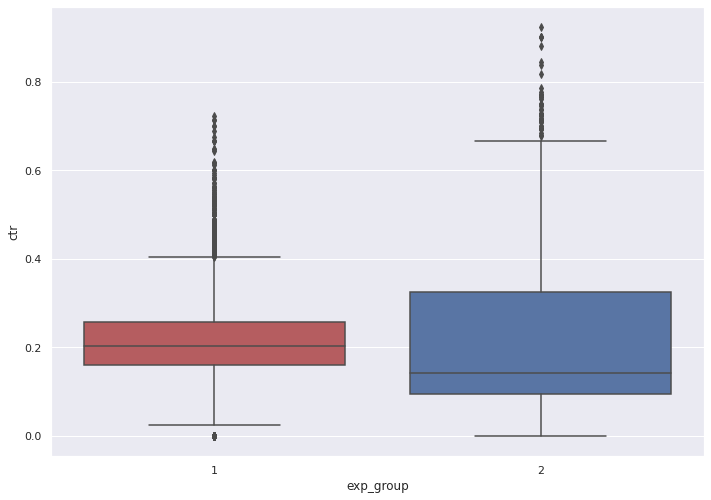

In [8]:
sns.boxplot(data=df, y='ctr', x='exp_group', palette = ['r', 'b'])

На основании графика box plot отмечаем, что медианное значение CTR у группы 2 (экспериментальная) по своему значению меньше, чем у группы 1 (контрольная). 

1. Выполним анализ при помощи <b>t-test</b>:

In [9]:
#t-test
t_score, p_value = stats.ttest_ind(df[df.exp_group == 1].ctr,
                    df[df.exp_group == 2].ctr,
                    equal_var=False)

In [10]:
print('Значение статистики t-test:', t_score, 'Значение p-value:', p_value)

Значение статистики t-test: 0.7094392041270486 Значение p-value: 0.4780623130874935


In [11]:
# Critical t-test value
stats.t.ppf(1 - alpha / 2, df[df.exp_group.isin([1, 2])].size - 2)

1.9599876712934454

Описание результата t-test: значение полученной статистики меньше критического значения, а значение p-value значительно выше принятого уровня значимоти 0.05. Следовательно нет оснований отвергнуть нулевую гипотезу о равенстве средних генеральных совокупностей. Однако, следует отметить, что характер распределения для группы 2 заметно отличается от нормального, поэтому корректность результатов t-testа следует оставить под вопросом.

2. Выполним анализ при помощи теста <b>Манна-Уитни</b>:

In [12]:
# Mann-Whitney test
stats.mannwhitneyu(df[df.exp_group == 1].ctr,
df[df.exp_group == 2].ctr,
alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Описание результата теста Манна-Уитни: значение p-value значительно ниже принятого уровня значимоти 0.05. Следовательно есть основания отвергнуть нулевую гипотезу о равенстве средних генеральных совокупностей.

3. <b>Пуассоновский бутстреп<b/>

Учитывая результаты теста Манна-Уитни оценим разность глобальных CTR для рассматриваемых групп 1 и 2:

In [13]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    
    poisson_bootstraps1 = stats.poisson(1).rvs(
    (n_bootstrap, len(likes1))).astype(np.int64)
    
    poisson_bootstraps2 = stats.poisson(1).rvs(
    (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1 * likes1).sum(axis=1) / (poisson_bootstraps1 * views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2 * likes2).sum(axis=1) / (poisson_bootstraps2 * views2).sum(axis=1)
    
    return globalCTR1, globalCTR2

In [14]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

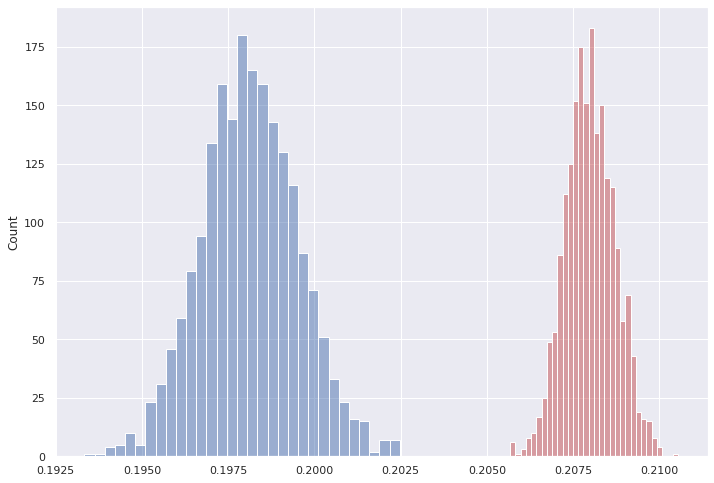

In [15]:
#1st group (red) - control
sns.histplot(data = ctr1,
alpha=0.5,
color='r',
kde=False)

#2nd group (blue) - new algorytm
sns.histplot(data = ctr2,
alpha=0.5,
color='b',
kde=False)

График разности глобальных CTR для рассматриваемых групп 1 и 2:

<AxesSubplot:ylabel='Count'>

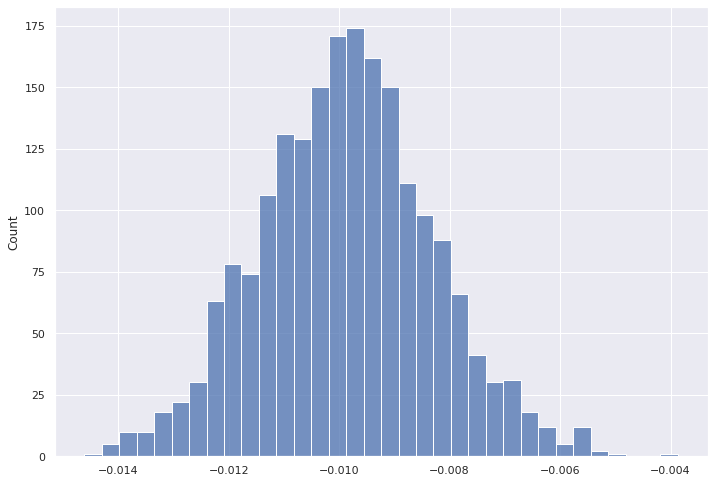

In [16]:
sns.histplot(ctr2 - ctr1)

<b>Выводы</b>: для анализа были применены методы Манна-Уитни и Пуассоновский бутстреп. Результаты анализа показали, что при выбранном уровне значимости 0.05 существуют статистически значимые отличия между распределениями CTR групп 1 и 2. С помощью Пуассоновского бутстрепа было оценено смещение распределения групповых CTR экспериментальной группы 2 относительно контрольной группы 1 - оно оказалось отрицательным. Это означает, что по итогам эксперимента имеет место негативный эффект, приводящий к ухудшению группового CTR.<br>
Следовательно новый алгоритм рекомендаций "похожих на лайкнутые постов" внедрять не стоит.<br>
Учитывая характер получившегося распределения пользовательских CTR (первая гисторамма) можно предположить, что в реализованном алгоритме не быди учтены эффекты, которые в процессе AB тестирования побудили людей разделиться на две неравные группы (например, пользователи из РФ начали получать в качестве рекомендаций похожие по содержанию на ранее лайкнутые новости, но из других стран).